# THESIS - Model 

# Imports 

In [1]:
#imports

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import shlex, subprocess
import os , sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from Bio import SeqIO
import time

2023-02-11 15:21:17.161901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Preparation of the dataset 
- One hot encoding the sequences 

In [2]:
#this should work now 
def fasta_to_onehotencode(seq) : 
    #values = list(seq)
    #values = np.array(values)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # label = int(line.strip()[1])
    
    
    sequence = seq #f.readline().strip()
    # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
    sequence_int = [base2int.get(base, 9999) for base in sequence]
    
    sequence_onehot = tf.one_hot(sequence_int, depth=4)
    
        
    return sequence_onehot

In [3]:
def fastatoarray(fasta_sequences) :
    seq_array = np.zeros((1,400,4)) 
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        new_sequence = fasta_to_onehotencode(sequence) #onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))
    seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
    return seq_array                    

In [4]:
_start_time = time.time()
#change a bit this function or cite 
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [122]:
#dataset upload, keeping the first four folders for training and testing and the last one for validation --> try with matrices not list

#/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/AARS_K562/fold-0/
from Bio import SeqIO
path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)


tic()

for folder in directory1:

    if folder == 'AARS_K562': #to be removed later 
        current_folder = folder
        directory2 = os.listdir(path + '/' + folder)
        
        seq_list_positive = np.zeros((1,400,4)) 
        seq_list_negative = np.zeros((1,400,4)) 
        seq_list_positive_test = np.zeros((1,400,4)) 
        seq_list_negative_test = np.zeros((1,400,4)) 
        
        for folder2 in directory2 :
            directory3 = os.listdir(path+ '/' + folder + '/' + folder2)
            
            if folder2 != "fold-4": #to be split into training and validation
            
                seq_list_positive_file = np.zeros((1,400,4)) 
                seq_list_negative_file = np.zeros((1,400,4)) 

                for file in directory3 :

                    if "fasta" in file :
                        fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                        seq_array = fastatoarray(fasta_sequences)
                        
                        if "positive" in file : 
                            seq_list_positive_file = np.vstack((seq_list_positive_file, seq_array))


                        if "negative-1" in file: # 2 neg: 1 pos with 'negative' --> 1 neg : 1 pos 'negative-1'
                            seq_list_negative_file = np.vstack((seq_list_negative_file, seq_array))
                            
                seq_list_negative_file = np.delete(seq_list_negative_file, 0, 0)
                seq_list_positive_file = np.delete(seq_list_positive_file, 0, 0)

                seq_list_positive = np.vstack((seq_list_positive, seq_list_positive_file))
                seq_list_negative = np.vstack((seq_list_negative, seq_list_negative_file))

  
                
            if folder2 == "fold-4": #for testing
                     
                    seq_list_positive_test_file = np.zeros((1,400,4)) 
                    seq_list_negative_test_file = np.zeros((1,400,4)) 

                    for file in directory3 :

                        if "fasta" in file :
                            fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                            seq_array = fastatoarray(fasta_sequences)

                            if "positive" in file : 
                                seq_list_positive_test_file = np.vstack((seq_list_positive_test_file, seq_array))
 

                            if "negative-1" in file: 
                                seq_list_negative_test_file = np.vstack((seq_list_negative_test_file, seq_array))
 
                    seq_list_negative_test_file = np.delete(seq_list_negative_test_file, 0, 0)
                    seq_list_positive_test_file = np.delete(seq_list_positive_test_file, 0, 0)

                    seq_list_positive_test = np.vstack((seq_list_positive_test, seq_list_positive_test_file))
                    seq_list_negative_test = np.vstack((seq_list_negative_test, seq_list_negative_test_file))
    
                    seq_list_negative_test = np.delete(seq_list_negative_test, 0, 0)
                    seq_list_positive_test = np.delete(seq_list_positive_test, 0, 0)  

        
                  
        seq_list_negative = np.delete(seq_list_negative, 0, 0)
        seq_list_positive = np.delete(seq_list_positive, 0, 0)

        


            
tac()


Time passed: 0hour:0min:12sec


- Preparation of the labels 

In [6]:
#preparation of the labels for the positive and negative dataset and validation set

labels_positive = np.ones((np.shape(seq_list_positive)[0], 1))

labels_negative = np.zeros((np.shape(seq_list_negative)[0], 1))
 
labels_positive_test = np.ones((np.shape(seq_list_positive_test)[0], 1))

labels_negative_test = np.zeros((np.shape(seq_list_negative_test)[0], 1))
print('Shape of labels: \n-positive : ',np.shape(labels_negative),'\n-negative : ', np.shape(labels_negative),'\n-positive validation : ',np.shape(labels_positive_test),'\n-negative validation : ',np.shape(labels_negative_test))

Shape of labels: 
-positive :  (2667, 1) 
-negative :  (2667, 1) 
-positive validation :  (720, 1) 
-negative validation :  (720, 1)


In [7]:
#merging the positive and negative datasets 
x = np.vstack((seq_list_positive, seq_list_negative))

x_test = np.vstack((seq_list_positive_test, seq_list_negative_test))

y = np.vstack((labels_positive, labels_negative))

y_test = np.vstack((labels_positive_test, labels_negative_test))


- Splitting of the dataset : test, train and validation sets 

In [8]:
#creation of the validation set 
import numpy as np
from sklearn.model_selection import train_test_split

#parameters 
test_size = 0.2

#test set

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle= True)

y_train = y_train.astype("float32")#actually useful?
y_val =y_val.astype("float32")
y_test = y_test.astype("float32")

x_train = x_train.astype("float32")
x_val = x_val.astype("float32")
x_test =x_test.astype("float32")



print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-validation set : ',np.shape(x_val),'\n-testing set : ', np.shape(x_test))

Shape of datasets: 
-training set :  (4267, 400, 4) 
-validation set :  (1067, 400, 4) 
-testing set :  (1440, 400, 4)


In [ ]:
# Prepare the training dataset. --> I HAVE AVOIDED THIS STEP OTHERWISE THE MODEL DOES NOT RUN 
#parameters
batch_size = 32 #--> how much should be my batch size? 
buffer_size = len(x_train) + 100 #For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
buffer_size_test= len(x_test) + 100

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size) 

# Prepare the testing dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size=buffer_size_test).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

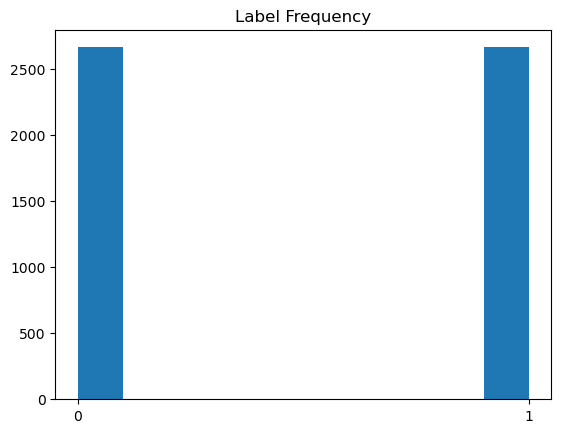

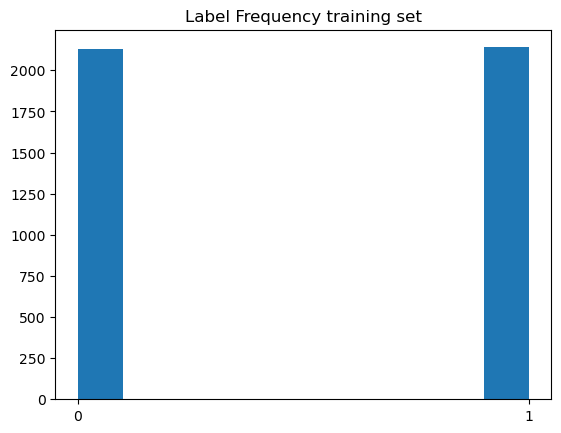

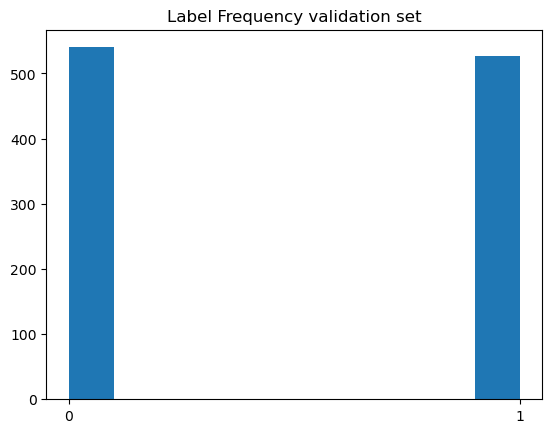

In [9]:
#checking class ditribution in the whole dataset and training set
import matplotlib.pyplot as plt

plt.hist(y)
plt.xticks(range(2))
plt.title('Label Frequency')
plt.show()

plt.hist(y_train)
plt.xticks(range(2))
plt.title('Label Frequency training set')
plt.show()

plt.hist(y_val)
plt.xticks(range(2))
plt.title('Label Frequency validation set')
plt.show()

# 2. Model  

# 2.1 .compile() 
- Create the baseline model 

In [14]:
#first is .compile() --> to create the baseline model : no dataset
def create_baseline():
    from tensorflow.keras.optimizers.legacy import Adam
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (400, 4)
    #batch_size = 32 # --> when batching the dataset, the model gives a graph error 
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))#, batch_size=batch_size))
    #model.add(keras.layers.Dropout(0.3)) -- seems better without this step
    
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer='random_normal', #to be changed once I have the actual input data -- from constant 1 ato random normal
             #glorot_uniform(seed=12)
              activation='relu'))#,input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer= 'random_normal', 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters

    model.add(keras.layers.Dense(1024, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(keras.layers.Dropout(0.6))
    
    model.add(keras.layers.Dense(128, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # for binary classification
    
    #model.compile( optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),# Optimizer
                    # Loss function to minimize
                    #loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    #metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model


In [113]:
#tuning of the model architecture 
def build_model(hp):
    
    
    from tensorflow.keras.optimizers.legacy import Adam
   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    #parameters 
    input_shape = (400, 4)
    #batch_size = 32 # --> when batching the dataset, the model gives a graph error 
    filters = 30
    kernel_size = 25
    pool_size = 2
    strides = 2
    #activation ? 
    #kernel_initializer ? 
    loss='binary_crossentropy'
    optimizer='adam' 
    metrics=['accuracy']
    
    # create model
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))#, batch_size=batch_size))
    #model.add(keras.layers.Dropout(0.3)) -- seems better without this step
    
    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,#kernel_size is kernel length right? 
              kernel_initializer='random_normal', #to be changed once I have the actual input data -- from constant 1 ato random normal
             #glorot_uniform(seed=12)
              activation='relu'))#,input_shape=input_shape[1:])) #--> idk what to add
             #or without data? )
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))#valid or same? padding or not 
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=filters,kernel_size=kernel_size,
              kernel_initializer= 'random_normal', 
             #glorot_uniform(seed=12)
              activation='relu',input_shape=input_shape ))#--> idk what to add

    model.add(keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides, padding='valid'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters
    
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_{i}", min_value=32, max_value=1024, step=32),
            activation = 'relu'
            #activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="relu"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    

    #model.add(keras.layers.Dense(1024, activation='relu'))#is it always relu? also sigmoid is an option
    '''model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=128, max_value=2400, step=32),
            activation="relu",
        )
    )
    model.add(keras.layers.Dropout(0.6))
    
    #model.add(keras.layers.Dense(128, activation='relu'))#is it always relu? also sigmoid is an option 
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            activation="relu",
        )
    )'''
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy']) # for binary classification
    
    #model.compile( optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),# Optimizer
                    # Loss function to minimize
                    #loss=keras.losses.BinaryCrossentropy(),
                    # List of metrics to monitor
                    #metrics=[keras.metrics.BinaryAccuracy()],)
        #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # for multi class
    return model
    
    

In [114]:
import keras_tuner

model1 = build_model(keras_tuner.HyperParameters())

print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 376, 30)           3030      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 188, 30)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 188, 30)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 164, 30)           22530     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 82, 30)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 82, 30)           

In [115]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="accuracy", #val_loss , val_accuracy .... 
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [116]:
tuner.search_space_summary()


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [117]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 5 Complete [00h 00m 26s]
accuracy: 0.6414342522621155

Best accuracy So Far: 0.7426763574282328
Total elapsed time: 00h 02m 16s
INFO:tensorflow:Oracle triggered exit


In [118]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=4)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 400, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 376, 30)           3030      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 188, 30)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 188, 30)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 30)           22530     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 30)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 82, 30)            0

In [119]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 896
dropout: True
lr: 0.0004893954054196937
units_1: 32
units_2: 32
Score: 0.7426763574282328
Trial summary
Hyperparameters:
num_layers: 3
units_0: 192
dropout: True
lr: 0.0016380235981496075
units_1: 800
units_2: 192
Score: 0.7310366233189901
Trial summary
Hyperparameters:
num_layers: 1
units_0: 960
dropout: False
lr: 0.00035910093218825
units_1: 32
units_2: 64
Score: 0.6654948790868124
Trial summary
Hyperparameters:
num_layers: 1
units_0: 384
dropout: False
lr: 0.00024335509762462415
units_1: 224
units_2: 160
Score: 0.6505741675694784
Trial summary
Hyperparameters:
num_layers: 2
units_0: 448
dropout: False
lr: 0.000501777635589437
units_1: 96
units_2: 928
Score: 0.6414342522621155


In [120]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model1 = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
model1.fit(x=x_all, y=y_all, epochs=10)

Epoch 1/10
167/167 [==============================] - 3s 13ms/step - loss: 0.6472 - accuracy: 0.6067
Epoch 2/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5869 - accuracy: 0.6775
Epoch 3/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5748 - accuracy: 0.6910
Epoch 4/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5512 - accuracy: 0.7372
Epoch 5/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5430 - accuracy: 0.7492
Epoch 6/10
167/167 [==============================] - 2s 13ms/step - loss: 0.5328 - accuracy: 0.7572
Epoch 7/10
167/167 [==============================] - 2s 12ms/step - loss: 0.5100 - accuracy: 0.7778
Epoch 8/10
167/167 [==============================] - 2s 13ms/step - loss: 0.4907 - accuracy: 0.7898
Epoch 9/10
167/167 [==============================] - 2s 12ms/step - loss: 0.4778 - accuracy: 0.7992
Epoch 10/10
167/167 [==============================] - 2s 12ms/step - loss: 0.4595 - accura

In [132]:
model1.save('best_models/best_model_%s' % current_folder)

INFO:tensorflow:Assets written to: best_models/best_model_AARS_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model_AARS_K562/assets


In [131]:
print('best_models/best_model_%s' % current_folder)

best_models/best_model_AARS_K562


In [15]:
model = create_baseline()

print(model.layers)

print(model.summary()) 

[<keras.layers.convolutional.conv1d.Conv1D object at 0x7fdfd06b3be0>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7fdfd06b3b80>, <keras.layers.regularization.dropout.Dropout object at 0x7fdfd06b1cc0>, <keras.layers.convolutional.conv1d.Conv1D object at 0x7fdfd06b3190>, <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x7fdfd07041c0>, <keras.layers.regularization.dropout.Dropout object at 0x7fe06695d150>, <keras.layers.reshaping.flatten.Flatten object at 0x7fe0141091e0>, <keras.layers.core.dense.Dense object at 0x7fdfd0704ac0>, <keras.layers.regularization.dropout.Dropout object at 0x7fdfd0706140>, <keras.layers.core.dense.Dense object at 0x7fdfd0706b00>, <keras.layers.regularization.dropout.Dropout object at 0x7fdfd0707430>, <keras.layers.core.dense.Dense object at 0x7fdfd0704d30>]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)        

In [15]:
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

#showing the mean and standard deviation of the estimated accuracy of the model on unseen data.

In [34]:
estimator = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold) #change to x_val and y_val
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 76.35% (1.57%)


# 2.2 .fit() 
- Training the model 

In [22]:
%load_ext tensorboard
%rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 118890), started 0:52:08 ago. (Use '!kill 118890' to kill it.)

In [16]:
#second is to use .fit() --> to train the model : use x_train, y_train --> either .fit() or training loop from scratch (see below)
print("Fit model on training data")

model = create_baseline()

import datetime
#%tensorboard --logdir logs/fit
#parameters 
#batch_size=32
epochs= 40

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


history = model.fit(
    x_train,
    y_train,
    #batch_size=batch_size, # --> the tf.dataset already batched the dataset 
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val,y_val),
    callbacks=my_callbacks
)

Fit model on training data
Epoch 1/40
134/134 [==============================] - 4s 21ms/step - loss: 0.6305 - accuracy: 0.6435 - val_loss: 0.5477 - val_accuracy: 0.7291
Epoch 2/40
134/134 [==============================] - 2s 16ms/step - loss: 0.5477 - accuracy: 0.7338 - val_loss: 0.5565 - val_accuracy: 0.7245
Epoch 3/40
134/134 [==============================] - 2s 15ms/step - loss: 0.5252 - accuracy: 0.7483 - val_loss: 0.5346 - val_accuracy: 0.7545
Epoch 4/40
134/134 [==============================] - 2s 15ms/step - loss: 0.5031 - accuracy: 0.7607 - val_loss: 0.4870 - val_accuracy: 0.7835
Epoch 5/40
134/134 [==============================] - 2s 16ms/step - loss: 0.4877 - accuracy: 0.7785 - val_loss: 0.4730 - val_accuracy: 0.8004
Epoch 6/40
134/134 [==============================] - 2s 15ms/step - loss: 0.4628 - accuracy: 0.7898 - val_loss: 0.4836 - val_accuracy: 0.7882
Epoch 7/40
134/134 [==============================] - 2s 16ms/step - loss: 0.4403 - accuracy: 0.7966 - val_loss: 0.

In [14]:
#second is to use .fit() --> to train the model : use x_train, y_train --> either .fit() or training loop from scratch (see below)
print("Fit model on training data")
#%tensorboard --logdir logs/fit

model = create_baseline()

#parameters 
#batch_size=32
epochs= 20


history = model.fit(
    x_train,
    y_train,
    #batch_size=batch_size, --> the tf.dataset already batched the dataset 
    epochs=epochs
)

Fit model on training data
Epoch 1/20
134/134 [==============================] - 3s 14ms/step - loss: 0.6202 - accuracy: 0.6508
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.5504 - accuracy: 0.7324
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.5203 - accuracy: 0.7528
Epoch 4/20
134/134 [==============================] - 2s 14ms/step - loss: 0.5061 - accuracy: 0.7663
Epoch 5/20
134/134 [==============================] - 2s 14ms/step - loss: 0.4772 - accuracy: 0.7813
Epoch 6/20
134/134 [==============================] - 2s 14ms/step - loss: 0.4515 - accuracy: 0.7954
Epoch 7/20
134/134 [==============================] - 2s 14ms/step - loss: 0.4237 - accuracy: 0.8092
Epoch 8/20
134/134 [==============================] - 2s 14ms/step - loss: 0.4064 - accuracy: 0.8163
Epoch 9/20
134/134 [==============================] - 2s 14ms/step - loss: 0.3805 - accuracy: 0.8399
Epoch 10/20
134/134 [==============================] - 2s 14ms/s

In [25]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 118890), started 0:53:20 ago. (Use '!kill 118890' to kill it.)

In [20]:
#first attempt of a training loop from scratch --> added the evaluation loop here --> WORKS WITH TF.DATASETS

model = create_baseline()


#parameters
#input_shape = (3388, 401, 4)
input_shape = (400, 4)
epochs = 20 #for the test 
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)#parameter is recommended as true but creates an error
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()


model = create_baseline()

import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    #for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #55 steps
        #print(step)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
        logits = model(x_train, training=True)  
            #print("Number of weights after calling the model:", len(model.weights))

            # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_train, logits)
    
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights)) #I think it doesn't work because there's just one class now . 

        # Log every 200 batches.
        #if (step % 50) == 0:
         #   print(
          #      "Training loss (for one batch) at step %d: %.4f"
            #    % (step, float(loss_value))
            #)
            #print("Seen so far: %s samples" % ((step + 1) * batch_size))
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print(train_acc)
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
   # for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_val, training=False)

        # Update val metrics
    val_acc_metric.update_state(y_val, val_logits)
    
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    


Start of epoch 0


/home/icb/sofia.martello/miniconda3/envs/my-thesis-env/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.5061
Time taken: 0.89s

Start of epoch 1
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.5061
Time taken: 0.83s

Start of epoch 2
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.5342
Time taken: 0.82s

Start of epoch 3
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.4939
Time taken: 0.80s

Start of epoch 4
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.4939
Time taken: 0.82s

Start of epoch 5
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.4939
Time taken: 0.81s

Start of epoch 6
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation acc: 0.4939
Time taken: 0.81s

Start of epoch 7
tf.Tensor(0.0, shape=(), dtype=float32)
Training acc over epoch: 0.0000
Validation 

In [26]:
#first attempt of a training loop from scratch --> added the evaluation loop here --> WORKS WITH TF.DATASETS

#parameters
#input_shape = (3388, 401, 4)
input_shape = (400, 4)
epochs = 5 #for the test 
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)#or adam ? --> check  
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)#parameter is recommended as true 
# Prepare the metrics.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()


model = create_baseline()

import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset): #55 steps
        #print(step)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  
            #print("Number of weights after calling the model:", len(model.weights))

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
    
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
    

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) #I think it doesn't work because there's just one class now . 

        # Log every 200 batches.
        if (step % 50) == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)

        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    


Start of epoch 0


NameError: name 'train_dataset' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_class = y_pred_pos > threshold
cm = confusion_matrix(y_true, y_pred_class)
tn, fp, fn, tp = cm.ravel()